In [18]:
import pandas as pd
import re
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import random as rand
import numpy as np
import math

In [19]:
random = 24

In [20]:
data = pd.read_csv('games.csv')
random = 24
data = data[["Metacritic", "Indie", "Presence", "Platform", 
             "Memory", "RatingsBreakdown", "ReleaseDate", "Soundtrack", 
             "OriginalCost", "DiscountedCost", "Controller",
             "Achievements", "Languages", "Storage", "Tags"]]

In [21]:
data.describe(include= 'all')

,Metacritic,Indie,Presence,Platform,Memory,RatingsBreakdown,ReleaseDate,Soundtrack,OriginalCost,DiscountedCost,Controller,Achievements,Languages,Storage,Tags
count,3356.000000,30045.000000,3.015600e+04,30123,28316,15044,27024,30045.000000,29504,727,29976.000000,30156.000000,30027,27491,30045
unique,NaN,NaN,NaN,2041,699,4806,4133,NaN,396,121,NaN,NaN,3196,2067,24866
top,NaN,NaN,NaN,PC,2 GB RAM,meh: 1,2018-08-22,NaN,$9.99,$0.49,NaN,NaN,English,1 GB available space,"Adventure, Casual, Hidden Object"
freq,NaN,NaN,NaN,15720,6487,910,238,NaN,4144,260,NaN,NaN,17133,2303,258
mean,72.924911,0.740722,8.822923e+04,NaN,NaN,NaN,NaN,0.004760,NaN,NaN,0.457666,41.047984,NaN,NaN,NaN
std,10.805296,0.438246,2.447597e+05,NaN,NaN,NaN,NaN,0.068826,NaN,NaN,0.498213,316.231316,NaN,NaN,NaN
min,20.000000,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,67.000000,0.000000,1.890000e+02,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
50%,74.000000,1.000000,3.380000e+02,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
75%,80.000000,1.000000,4.981500e+03,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000,21.000000,NaN,NaN,NaN


In [22]:
for name in data.columns:
    lis = data[name].unique()
    print('\033[1m'+name+'\033[0;0m')
    print(lis)

m RAM                      ' '1 GB RAM GB RAM'
 '2 GB MB RAM' '00 MB RAM' '1200 MB RAM' '270 MB ' '8 GB MB RAM'
 '512 MB of RAM or more ' '512 MB MB RAM' '120 MB RAM'
 '2GB                       '
 '512 MB of RAM for Windows(R) XP or 1 GB of RAM for Windows Vista(TM) '
 '512 Mb                     ' '500MB RAM ' '1024 MB '
 'WinXP - 1Gbyte RAM' '1 GB (2GB for Vista or Windows 7) '
 '256 MB RAM 512 MB RAM recommended) ' '512 MB ОЗУ MB RAM'
 '512MB (Vista 1GB)\t'
 '128Mb or more free system memory                     '
 '128 MB (256 MB on 2000/NT/XP) ' '512 МB RAM '
 '1 GB (2 GB recommended for Windows Vista and Windows 7) ' '17 MB RAM'
 '1GB System Memory ' 'Windows XP：1GB' '6094 MB RAM' '965 MB RAM'
 '1024 MB RAM ' '512 RAM ' '768 Mb MB RAM' '512m'
 '1 Gb RAM (2 Gb or greater recommended) ' '4 GB MB RAM' '64MB minimum '
 '2Gb VRAM MB RAM' '64 MB RAM (128 MB Recommended) '
 '2 GB of available system memory' '1GB RAM\t   \t ' '512 MB minimum'
 '128MB or higher' '512MB of System RA'
 '1 G

In [23]:
actions = {k:[] for k in data.columns}
actions['Indie'].append(lambda x: x == 1.0) 
actions['Controller'].append(lambda x: x == 1.0) 
actions['Soundtrack'].append(lambda x: x == 1.0)
actions['ReleaseDate'].append(lambda x: int(x.split('-')[0]))

def replace_MB(x):
    x = str(x).lower()
    first = re.search(r"\d", x)
    if (first == None):
        return None
    first = first.start()
    i = first+1
    while(i<len(x) and (x[i].isdigit() or x[i] == '.')):
        i = i+1
    last = i
    while(i<len(x) and x[i:i+2] != "gb" and x[i:i+2] != "mb"):
        i = i+1
    if (i == len(x) or x[i:i+2] == "gb"):
        return(float(x[first:last])*1000)
    return(float(x[first:last]))


def clean_originalCost(x):
    x = str(x).replace('$', '')
    try:
        number = float(x)
        return number
    except:
        return 0


actions['OriginalCost'].append(lambda x: clean_originalCost(x))
actions['OriginalCost'].append(lambda x: float(str(x).replace('$', '')))
actions['DiscountedCost'].append(lambda x: float(str(x).replace('$', '')))
actions['Storage'].append(lambda x: replace_MB(x))
actions['Memory'].append(lambda x: replace_MB(x))

for name in actions:
    for action in actions[name]:
        data.loc[:,name] = data[data[name].notna()][name].apply(action)

data['DiscountedCost'] = data['DiscountedCost'].fillna(0)
data

,Metacritic,Indie,Presence,Platform,Memory,RatingsBreakdown,ReleaseDate,Soundtrack,OriginalCost,DiscountedCost,Controller,Achievements,Languages,Storage,Tags
0,83.0,False,1009588.0,"PC, Xbox 360, PlayStation 3",2000.0,"recommended: 882, meh: 501, exceptional: 283, ...",2012.0,False,0.00,0.0,True,179.0,"English, Czech, Danish, Dutch, Finnish, French...",15000.0,"FPS, Shooter, Multiplayer, Competitive, Action..."
1,82.0,False,1007425.0,"PlayStation 5, Web, Xbox Series X, PC, Xbox On...",6000.0,"recommended: 726, meh: 465, exceptional: 227, ...",2017.0,False,0.00,0.0,True,61.0,"English, French, Italian, German, Japanese, Ko...",105000.0,"Free to Play, Looter Shooter, FPS, Multiplayer..."
2,90.0,False,1009306.0,"Linux, macOS, PC",4000.0,"meh: 496, recommended: 446, skip: 371, excepti...",2013.0,False,0.00,0.0,True,0.0,"English, Bulgarian, Czech, Danish, Dutch, Finn...",15000.0,"Free to Play, MOBA, Multiplayer, Strategy, eSp..."
3,71.0,False,1000781.0,PC,3000.0,"recommended: 21, meh: 12, exceptional: 5, skip: 1",2014.0,False,19.99,0.0,True,0.0,"English, French, German, Russian",85000.0,"RPG, MMORPG, Open World, Massively Multiplayer..."
4,68.0,False,777456.0,"PC, Xbox One",4000.0,"recommended: 198, meh: 131, exceptional: 62, s...",2018.0,False,39.99,0.0,True,308.0,"English, French, Italian, German, Russian",50000.0,"Adventure, Action, Pirates, Open World, Multip..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30245,NaN,True,105.0,PC,512.0,NaN,2018.0,False,0.99,0.0,True,0.0,English,10.0,"Indie, Casual"
30246,NaN,True,13.0,PC,6000.0,NaN,2017.0,False,0.99,0.0,False,0.0,English,2000.0,"Indie, Puzzle, Pixel Graphics, Mystery, Experi..."
30247,NaN,False,11.0,PC,2048.0,NaN,2018.0,False,1.99,0.0,False,0.0,English,2048.0,Casual
30248,NaN,True,423.0,PC,500.0,NaN,2017.0,False,0.99,0.0,True,0.0,English,300.0,"Action, Adventure, Indie, Casual"


In [24]:
platform = pd.Series(data['Platform']).str.get_dummies(', ')
platform.columns
data['Platform-Mobile'] = platform[['Android','iOS']].sum(axis = 1).apply(lambda x: x > 0) 
data['Platform-PC'] = platform[['Apple II','Atari ST', 'Classic Macintosh', 'Commodore / Amiga',  'Linux', 'PC', 'Web', 'macOS']].sum(axis = 1).apply(lambda x: x > 0)  
data['Platform-Xbox'] = platform[['Xbox', 'Xbox 360', 'Xbox One']].sum(axis = 1).apply(lambda x: x > 0)  
data['Platform-PlayStation'] = platform[['PS Vita', 'PSP', 'PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStation 4']].sum(axis = 1).apply(lambda x: x > 0)  
data['Platform-Nintendo'] = platform[['Game Boy', 'GameCube', 'Nintendo 3DS', 'Nintendo DS', 'Nintendo Switch', 'Wii', 'Wii U']].sum(axis = 1).apply(lambda x: x > 0) 
data['Platform-Sega'] = platform[['Dreamcast','Game Gear','Genesis','SEGA Master System', 'SEGA Saturn']].sum(axis = 1).apply(lambda x: x > 0) 
data

,Metacritic,Indie,Presence,Platform,Memory,RatingsBreakdown,ReleaseDate,Soundtrack,OriginalCost,DiscountedCost,...,Achievements,Languages,Storage,Tags,Platform-Mobile,Platform-PC,Platform-Xbox,Platform-PlayStation,Platform-Nintendo,Platform-Sega
0,83.0,False,1009588.0,"PC, Xbox 360, PlayStation 3",2000.0,"recommended: 882, meh: 501, exceptional: 283, ...",2012.0,False,0.00,0.0,...,179.0,"English, Czech, Danish, Dutch, Finnish, French...",15000.0,"FPS, Shooter, Multiplayer, Competitive, Action...",False,True,True,True,False,False
1,82.0,False,1007425.0,"PlayStation 5, Web, Xbox Series X, PC, Xbox On...",6000.0,"recommended: 726, meh: 465, exceptional: 227, ...",2017.0,False,0.00,0.0,...,61.0,"English, French, Italian, German, Japanese, Ko...",105000.0,"Free to Play, Looter Shooter, FPS, Multiplayer...",False,True,True,True,False,False
2,90.0,False,1009306.0,"Linux, macOS, PC",4000.0,"meh: 496, recommended: 446, skip: 371, excepti...",2013.0,False,0.00,0.0,...,0.0,"English, Bulgarian, Czech, Danish, Dutch, Finn...",15000.0,"Free to Play, MOBA, Multiplayer, Strategy, eSp...",False,True,False,False,False,False
3,71.0,False,1000781.0,PC,3000.0,"recommended: 21, meh: 12, exceptional: 5, skip: 1",2014.0,False,19.99,0.0,...,0.0,"English, French, German, Russian",85000.0,"RPG, MMORPG, Open World, Massively Multiplayer...",False,True,False,False,False,False
4,68.0,False,777456.0,"PC, Xbox One",4000.0,"recommended: 198, meh: 131, exceptional: 62, s...",2018.0,False,39.99,0.0,...,308.0,"English, French, Italian, German, Russian",50000.0,"Adventure, Action, Pirates, Open World, Multip...",False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30245,NaN,True,105.0,PC,512.0,NaN,2018.0,False,0.99,0.0,...,0.0,English,10.0,"Indie, Casual",False,True,False,False,False,False
30246,NaN,True,13.0,PC,6000.0,NaN,2017.0,False,0.99,0.0,...,0.0,English,2000.0,"Indie, Puzzle, Pixel Graphics, Mystery, Experi...",False,True,False,False,False,False
30247,NaN,False,11.0,PC,2048.0,NaN,2018.0,False,1.99,0.0,...,0.0,English,2048.0,Casual,False,True,False,False,False,False
30248,NaN,True,423.0,PC,500.0,NaN,2017.0,False,0.99,0.0,...,0.0,English,300.0,"Action, Adventure, Indie, Casual",False,True,False,False,False,False


In [25]:
def RatingsBreakdown(x):
    x = x.split(', ')
    result = [np.nan, np.nan, np.nan, np.nan]
    for i in x:
        if i.split(' ')[0] == 'recommended:':
            result[0] = float(i.split(' ')[1])
        elif i.split(' ')[0] == 'meh:':
            result[1] = float(i.split(' ')[1])
        elif i.split(' ')[0] == 'exceptional:':
            result[2] = float(i.split(' ')[1])
        elif i.split(' ')[0] == 'skip:':
            result[3] = float(i.split(' ')[1])
    return result  
        
df_aux = pd.DataFrame(data[data['RatingsBreakdown'].notna()]['RatingsBreakdown'].apply(lambda x: RatingsBreakdown(x)))
df_aux = pd.DataFrame(df_aux.RatingsBreakdown.values.tolist(),index = data[data['RatingsBreakdown'].notna()]['RatingsBreakdown'].index, columns=['RatingsBreakdown-Recommended','RatingsBreakdown-Meh','RatingsBreakdown-Exceptional','RatingsBreakdown-Skip'])
data = data.join(df_aux)
data

,Metacritic,Indie,Presence,Platform,Memory,RatingsBreakdown,ReleaseDate,Soundtrack,OriginalCost,DiscountedCost,...,Platform-Mobile,Platform-PC,Platform-Xbox,Platform-PlayStation,Platform-Nintendo,Platform-Sega,RatingsBreakdown-Recommended,RatingsBreakdown-Meh,RatingsBreakdown-Exceptional,RatingsBreakdown-Skip
0,83.0,False,1009588.0,"PC, Xbox 360, PlayStation 3",2000.0,"recommended: 882, meh: 501, exceptional: 283, ...",2012.0,False,0.00,0.0,...,False,True,True,True,False,False,882.0,501.0,283.0,185.0
1,82.0,False,1007425.0,"PlayStation 5, Web, Xbox Series X, PC, Xbox On...",6000.0,"recommended: 726, meh: 465, exceptional: 227, ...",2017.0,False,0.00,0.0,...,False,True,True,True,False,False,726.0,465.0,227.0,106.0
2,90.0,False,1009306.0,"Linux, macOS, PC",4000.0,"meh: 496, recommended: 446, skip: 371, excepti...",2013.0,False,0.00,0.0,...,False,True,False,False,False,False,446.0,496.0,228.0,371.0
3,71.0,False,1000781.0,PC,3000.0,"recommended: 21, meh: 12, exceptional: 5, skip: 1",2014.0,False,19.99,0.0,...,False,True,False,False,False,False,21.0,12.0,5.0,1.0
4,68.0,False,777456.0,"PC, Xbox One",4000.0,"recommended: 198, meh: 131, exceptional: 62, s...",2018.0,False,39.99,0.0,...,False,True,True,False,False,False,198.0,131.0,62.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30245,NaN,True,105.0,PC,512.0,NaN,2018.0,False,0.99,0.0,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN
30246,NaN,True,13.0,PC,6000.0,NaN,2017.0,False,0.99,0.0,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN
30247,NaN,False,11.0,PC,2048.0,NaN,2018.0,False,1.99,0.0,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN
30248,NaN,True,423.0,PC,500.0,NaN,2017.0,False,0.99,0.0,...,False,True,False,False,False,False,NaN,NaN,NaN,NaN


In [26]:
Tags = pd.Series(data['Tags']).str.get_dummies(', ').apply(lambda x: x > 0)
del Tags['Indie']
del Tags['Soundtrack']
del Tags['Controller']
Languages = pd.Series(data['Languages']).str.get_dummies(', ').apply(lambda x: x > 0)


data = data.join(Tags)
data = data.join(Languages)

In [27]:
del data['RatingsBreakdown']
del data['Platform']
del data['Tags']
del data['Languages']

In [28]:
for name in data.columns:
    print(name, data[name].isna().sum())

Metacritic 26894
Indie 205
Presence 94
Memory 1945
ReleaseDate 3226
Soundtrack 205
OriginalCost 746
DiscountedCost 0
Controller 274
Achievements 94
Storage 2762
Platform-Mobile 0
Platform-PC 0
Platform-Xbox 0
Platform-PlayStation 0
Platform-Nintendo 0
Platform-Sega 0
RatingsBreakdown-Recommended 20274
RatingsBreakdown-Meh 19575
RatingsBreakdown-Exceptional 22267
RatingsBreakdown-Skip 20356
1980s 0
1990's 0
2.5D 0
2D 0
2D Fighter 0
2D Platformer 0
360 Video 0
3D 0
3D Fighter 0
3D Platformer 0
3D Vision 0
4 Player Local 0
4X 0
6DOF 0
ATV 0
Abstract 0
Action 0
Action RPG 0
Action RTS 0
Action Roguelike 0
Action-Adventure 0
Addictive 0
Adventure 0
Agriculture 0
Aliens 0
Alternate History 0
Ambient 0
America 0
Animation & Modeling 0
Anime 0
Arcade 0
Archery 0
Arena Shooter 0
Artificial Intelligence 0
Assassin 0
Asymmetric VR 0
Asynchronous Multiplayer 0
Atmospheric 0
Audio Production 0
Auto Battler 0
Automation 0
Automobile Sim 0
BMX 0
Base Building 0
Baseball 0
Based On A Novel 0
Basketbal

In [29]:
for col in data.columns:
    if len(data[col].unique()) == 1:
        data.drop(col,inplace=True,axis=1)

In [30]:
for name in data.columns:
    lis = data[name].unique()
    print('\033[1m'+name+'\033[0;0m')
    print(lis)

 44. 108. 198.  16. 231. 149.  78. 137.  64.  79. 174. 211. 116.
 112. 386. 101. 195. 239.  99. 295. 187. 216.  96.  27. 277. 111. 119.
 142. 104.  98. 162.  58. 259.  88.  94. 207.  66. 273. 301.  83. 140.
 173. 132. 181. 113. 299. 103.  56.  57. 210. 151. 325. 130. 227. 183.
  81.  71. 138. 167. 107. 122. 172. 225. 159. 168. 201. 154. 155. 218.
 105. 286. 197. 238. 156. 182. 192. 180. 175. 164.]
RatingsBreakdown-Exceptional
[2.830e+02 2.270e+02 2.280e+02 5.000e+00 6.200e+01 2.100e+01 2.410e+02
 4.530e+02 3.600e+01 5.700e+01 2.269e+03 2.630e+02 2.190e+02 1.790e+02
 3.890e+02 1.859e+03 1.500e+01 9.000e+00 5.400e+01 2.900e+01       nan
 1.910e+02 4.100e+01 6.000e+00 1.850e+02 8.900e+01 1.680e+02 5.500e+01
 8.800e+01 6.290e+02 3.460e+02 1.400e+01 4.000e+00 5.300e+01 1.860e+02
 3.920e+02 6.530e+02 1.240e+02 1.300e+01 3.800e+01 1.510e+02 1.150e+02
 2.750e+02 6.590e+02 4.760e+02 6.500e+01 7.000e+00 1.800e+01 3.280e+02
 8.000e+00 1.130e+02 2.600e+01 1.000e+00 1.780e+02 9.600e+01 3.840e+02
 7

In [31]:
from scipy import stats

In [32]:
for name in data.columns:
    print(name)

Metacritic
Indie
Presence
Memory
ReleaseDate
Soundtrack
OriginalCost
DiscountedCost
Controller
Achievements
Storage
Platform-Mobile
Platform-PC
Platform-Xbox
Platform-PlayStation
Platform-Nintendo
Platform-Sega
RatingsBreakdown-Recommended
RatingsBreakdown-Meh
RatingsBreakdown-Exceptional
RatingsBreakdown-Skip
1980s
1990's
2.5D
2D
2D Fighter
2D Platformer
360 Video
3D
3D Fighter
3D Platformer
3D Vision
4 Player Local
4X
6DOF
ATV
Abstract
Action
Action RPG
Action RTS
Action Roguelike
Action-Adventure
Addictive
Adventure
Agriculture
Aliens
Alternate History
Ambient
America
Animation & Modeling
Anime
Arcade
Archery
Arena Shooter
Artificial Intelligence
Assassin
Asymmetric VR
Asynchronous Multiplayer
Atmospheric
Audio Production
Auto Battler
Automation
Automobile Sim
BMX
Base Building
Baseball
Based On A Novel
Basketball
Batman
Battle Royale
Beat 'em up
Beautiful
Benchmark
Bikes
Blood
Board Game
Bowling
Boxing
Breathtaking
Building
Bullet Hell
Bullet Time
CRPG
Capitalism
Card Battler
Card 

In [33]:
labels_num = ['Presence','Memory','ReleaseDate','OriginalCost','DiscountedCost','Achievements','Storage',
                'RatingsBreakdown-Recommended','RatingsBreakdown-Meh','RatingsBreakdown-Exceptional','RatingsBreakdown-Skip',
              'Metacritic','Controller', 'Indie', 'Soundtrack']
dataNum = data[labels_num]
dataNoNum = data[data.columns.difference(labels_num)]
dataNum

,Presence,Memory,ReleaseDate,OriginalCost,DiscountedCost,Achievements,Storage,RatingsBreakdown-Recommended,RatingsBreakdown-Meh,RatingsBreakdown-Exceptional,RatingsBreakdown-Skip,Metacritic,Controller,Indie,Soundtrack
0,1009588.0,2000.0,2012.0,0.00,0.0,179.0,15000.0,882.0,501.0,283.0,185.0,83.0,True,False,False
1,1007425.0,6000.0,2017.0,0.00,0.0,61.0,105000.0,726.0,465.0,227.0,106.0,82.0,True,False,False
2,1009306.0,4000.0,2013.0,0.00,0.0,0.0,15000.0,446.0,496.0,228.0,371.0,90.0,True,False,False
3,1000781.0,3000.0,2014.0,19.99,0.0,0.0,85000.0,21.0,12.0,5.0,1.0,71.0,True,False,False
4,777456.0,4000.0,2018.0,39.99,0.0,308.0,50000.0,198.0,131.0,62.0,39.0,68.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30245,105.0,512.0,2018.0,0.99,0.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,True,True,False
30246,13.0,6000.0,2017.0,0.99,0.0,0.0,2000.0,NaN,NaN,NaN,NaN,NaN,False,True,False
30247,11.0,2048.0,2018.0,1.99,0.0,0.0,2048.0,NaN,NaN,NaN,NaN,NaN,False,False,False
30248,423.0,500.0,2017.0,0.99,0.0,0.0,300.0,NaN,NaN,NaN,NaN,NaN,True,True,False


In [34]:
min_max_scaler = MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(dataNum.values)
data_imputed = KNNImputer(n_neighbors=5,weights='distance').fit_transform(pd.DataFrame(data_scaled))


data1 = pd.DataFrame(min_max_scaler.inverse_transform(data_imputed), columns = labels_num)
data2 = pd.DataFrame(dataNoNum.values, columns = data.columns.difference(labels_num))

data = data1.join(data2)
data

,Presence,Memory,ReleaseDate,OriginalCost,DiscountedCost,Achievements,Storage,RatingsBreakdown-Recommended,RatingsBreakdown-Meh,RatingsBreakdown-Exceptional,...,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,1009588.0,2000.0,2012.0,0.00,0.0,179.0,15000.0,882.000000,501.000000,283.000000,...,False,False,False,False,False,False,False,False,False,True
1,1007425.0,6000.0,2017.0,0.00,0.0,61.0,105000.0,726.000000,465.000000,227.000000,...,False,False,False,False,False,False,False,False,False,False
2,1009306.0,4000.0,2013.0,0.00,0.0,0.0,15000.0,446.000000,496.000000,228.000000,...,False,False,False,False,False,False,False,False,False,True
3,1000781.0,3000.0,2014.0,19.99,0.0,0.0,85000.0,21.000000,12.000000,5.000000,...,False,False,False,False,False,False,False,False,False,False
4,777456.0,4000.0,2018.0,39.99,0.0,308.0,50000.0,198.000000,131.000000,62.000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30245,105.0,512.0,2018.0,0.99,0.0,0.0,10.0,1.695128,1.000000,1.000000,...,False,False,False,False,False,False,False,False,False,False
30246,13.0,6000.0,2017.0,0.99,0.0,0.0,2000.0,1.166213,1.000000,1.207168,...,False,False,False,False,False,False,False,False,False,False
30247,11.0,2048.0,2018.0,1.99,0.0,0.0,2048.0,1.219932,1.283144,1.246388,...,False,False,False,False,False,False,False,False,False,False
30248,423.0,500.0,2017.0,0.99,0.0,0.0,300.0,1.338047,1.343133,1.000000,...,False,False,False,False,False,False,False,False,False,False


In [35]:
for name in data.columns:
    if data[name].isna().sum() > 0:
        print(name, data[name].isna().sum())

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
for name in data.columns:
    if data[name].isna().sum() > 0:
        print(name, data[name].isna().sum())

In [39]:
for name in labels_num:
    lis = data[name].unique()
    print('\033[1m'+name+'\033[0;0m')
    print(lis)

Presence
[1009588.  1007425.  1009306.  ...  226332.    45207.   164445.4]
Memory
[2.00000000e+03 6.00000000e+03 4.00000000e+03 ... 2.04204880e+07
 8.67801829e+02 2.00501682e+03]
ReleaseDate
[2012.         2017.         2013.         ... 2015.05607752 2017.41655376
 2017.77617622]
OriginalCost
[0.00000000e+00 1.99900000e+01 3.99900000e+01 2.99900000e+01
 5.99900000e+01 9.99000000e+00 4.49900000e+01 1.19900000e+01
 4.99900000e+01 2.10550433e+01 1.49900000e+01 3.49900000e+01
 2.12577307e+01 2.49900000e+01 2.08264672e+01 2.29900000e+01
 6.99900000e+01 2.10492717e+01 2.10965006e+01 5.99000000e+00
 3.75107320e+01 4.99500000e+00 1.83992114e+01 2.49907331e+01
 4.99000000e+00 2.10965006e+01 8.99000000e+00 2.10636475e+01
 1.79900000e+01 2.09900000e+01 2.99000000e+00 2.10965006e+01
 3.24426511e+01 5.87578874e+00 7.99000000e+00 1.59900000e+01
 2.12804880e+01 1.89062056e+01 3.71239377e+01 2.10818700e+01
 6.99000000e+00 1.69900000e+01 1.29900000e+01 2.44268741e+01
 3.19900000e+01 2.39900000e+01 2.1

In [40]:
for i in range(len(data['ReleaseDate'])):
    data.loc[i,'ReleaseDate'] = math.floor(data['ReleaseDate'][i])
    
for i in range(len(data['OriginalCost'])):
    data.loc[i,'OriginalCost'] = round(data['OriginalCost'][i], 2)

cols_to_round = ['Achievements', 'RatingsBreakdown-Recommended', 'RatingsBreakdown-Meh', 
                'RatingsBreakdown-Exceptional', 'RatingsBreakdown-Skip']
for colunm in cols_to_round:
    for i in range(len(data[colunm])):
        data.loc[i,colunm] = round(data[colunm][i])

In [41]:
data.loc[:,'Controller'] = data['Controller'].apply(lambda x: x > 0.5)
data.loc[:,'Indie'] = data['Indie'].apply(lambda x: x > 0.5)
data.loc[:,'Soundtrack'] = data['Soundtrack'].apply(lambda x: x > 0.5)

In [42]:
for name in data.columns:
    lis = data[name].unique()
    print('\033[1m'+name+'\033[0;0m')
    print(lis)
    print('Number of na: ' +str(data[name].isna().sum()))

Bullet Hell
[False  True]
Number of na: 0
Bullet Time
[False  True]
Number of na: 0
CRPG
[False  True]
Number of na: 0
Capitalism
[False  True]
Number of na: 0
Card Battler
[False  True]
Number of na: 0
Card Game
[False  True]
Number of na: 0
Cartoon
[False  True]
Number of na: 0
Cartoony
[False  True]
Number of na: 0
Casual
[False  True]
Number of na: 0
Cats
[False  True]
Number of na: 0
Character Action Game
[False  True]
Number of na: 0
Character Customization
[False  True]
Number of na: 0
Chess
[False  True]
Number of na: 0
Choices Matter
[False  True]
Number of na: 0
Choose Your Own Adventure
[False  True]
Number of na: 0
Cinematic
[False  True]
Number of na: 0
City Builder
[False  True]
Number of na: 0
Class-Based
[False  True]
Number of na: 0
Classic
[False  True]
Number of na: 0
Clicker
[False  True]
Number of na: 0
Co-op
[ True False]
Number of na: 0
Co-op Campaign
[False  True]
Number of na: 0
Cold War
[False  True]
Number of na: 0
Collectathon
[False  True]
Number of na: 0
C

In [43]:
col =['Presence',
'Memory',
'ReleaseDate',
'OriginalCost',
'DiscountedCost',
'Achievements',
'Storage',
'RatingsBreakdown-Recommended',
'RatingsBreakdown-Meh',
'RatingsBreakdown-Exceptional',
'RatingsBreakdown-Skip']
'''out = None
for name in col:
    data = data[~(np.abs(data[name] - data[name].mean()) > 1.5*data[name].std())]'''

'out = None\nfor name in col:\n    data = data[~(np.abs(data[name] - data[name].mean()) > 1.5*data[name].std())]'

In [44]:
from scipy import stats
data = data[(np.abs(stats.zscore(data[col])) < 3).all(axis=1)]

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 1.100e+01, 1.100e+01, 9.000e+00, 1.000e+01,
        1.000e+01, 1.400e+01, 1.300e+01, 2.500e+01, 3.000e+01, 4.000e+01,
        5.400e+01, 5.700e+01, 9.300e+01, 1.390e+02, 2.780e+02, 3.330e+02,
        5.020e+02, 5.070e+02, 1.034e+03, 1.300e+03, 1.296e+03, 1.872e+03,
        1.407e+03, 1.493e+03, 3.242e+03, 2.509e+03, 1.899e+03, 1.682e+03,
        2.221e+03, 2.401e+03, 8.520e+02, 7.380e+02, 2.630e+02, 2.820e+02,
        1.190e+02, 9.200e+01, 2.800e+01, 3.100e+01, 1.400e+01, 1.400e+01,
        3.000e+00, 9.000e+00]),
 array([20.  , 21.48, 22.96, 24.44, 25.92, 27.4 , 28.88, 30.36, 31.84,
        33.32, 34.8 , 36.28, 37.76, 39.24, 40.72, 42.2 , 43.68, 45.16,
        46.64, 48.12, 49.6 , 51.08, 52.56, 54.04, 55.52, 57.  , 58.48,
        59.96, 61.44, 62.92, 64.4 , 65.88, 67.36, 68.84, 70.32, 71.8 ,
        73.28, 74.76, 76.24, 77.72, 79.2 , 80.68, 82.16, 83.64, 85.12,
        86.6 , 88.08,

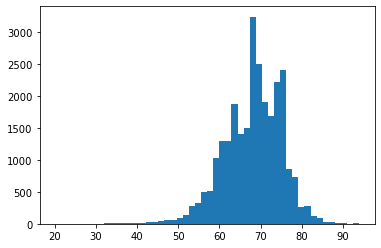

In [45]:
import matplotlib.pyplot as plt
plt.hist(data['Metacritic'], bins=50)

In [46]:
import pandas as pd
data['Metacritic'] = pd.qcut(data['Metacritic'], q=4)


In [47]:
data['Metacritic'].value_counts()

(73.573, 94.0]      6737
(68.619, 73.573]    6737
(63.527, 68.619]    6737
(19.999, 63.527]    6737
Name: Metacritic, dtype: int64

In [49]:
rand.seed(random)
x = [y for y in range(len(data))]
x = rand.sample(x, 10000)
data = data.iloc[x]
data

,Presence,Memory,ReleaseDate,OriginalCost,DiscountedCost,Achievements,Storage,RatingsBreakdown-Recommended,RatingsBreakdown-Meh,RatingsBreakdown-Exceptional,...,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
26497,41.0,2000.0,2017.0,5.99,0.0,0.0,450.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
14858,25415.0,1000.0,2012.0,3.99,0.0,44.0,120.0,4.0,9.0,1.0,...,False,False,False,False,False,False,False,False,False,False
21974,1421.0,4000.0,2016.0,1.99,0.0,0.0,2000.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
7696,257.0,4000.0,2013.0,9.99,0.0,20.0,12000.0,2.0,2.0,1.0,...,False,False,False,False,False,False,False,False,False,False
8997,250.0,256.0,2017.0,4.99,0.0,0.0,312.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25018,28.0,2000.0,2019.0,5.99,0.0,0.0,800.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2699,647.0,4000.0,2019.0,19.99,0.0,50.0,3000.0,11.0,2.0,8.0,...,False,False,False,False,False,False,False,False,False,False
21820,308.0,1000.0,2016.0,7.99,0.0,0.0,500.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
15183,253.0,8000.0,2017.0,12.99,0.0,0.0,600.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [50]:
data['Metacritic'].value_counts()

(73.573, 94.0]      2536
(68.619, 73.573]    2516
(63.527, 68.619]    2499
(19.999, 63.527]    2449
Name: Metacritic, dtype: int64

In [51]:
for col in data.columns:
    if len(data[col].unique()) == 1:
        data.drop(col,inplace=True,axis=1)

(19.999, 65.464]    600
(73.684, 94.0]      555
(69.955, 73.684]    541
(65.464, 69.955]    504
Name: Metacritic, dtype: int64

In [52]:
data.to_csv('games_clean.csv', index=False)

In [53]:
data

,Presence,Memory,ReleaseDate,OriginalCost,DiscountedCost,Achievements,Storage,RatingsBreakdown-Recommended,RatingsBreakdown-Meh,RatingsBreakdown-Exceptional,...,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
26497,41.0,2000.0,2017.0,5.99,0.0,0.0,450.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
14858,25415.0,1000.0,2012.0,3.99,0.0,44.0,120.0,4.0,9.0,1.0,...,False,False,False,False,False,False,False,False,False,False
21974,1421.0,4000.0,2016.0,1.99,0.0,0.0,2000.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
7696,257.0,4000.0,2013.0,9.99,0.0,20.0,12000.0,2.0,2.0,1.0,...,False,False,False,False,False,False,False,False,False,False
8997,250.0,256.0,2017.0,4.99,0.0,0.0,312.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25018,28.0,2000.0,2019.0,5.99,0.0,0.0,800.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2699,647.0,4000.0,2019.0,19.99,0.0,50.0,3000.0,11.0,2.0,8.0,...,False,False,False,False,False,False,False,False,False,False
21820,308.0,1000.0,2016.0,7.99,0.0,0.0,500.0,2.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False
15183,253.0,8000.0,2017.0,12.99,0.0,0.0,600.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,False,False


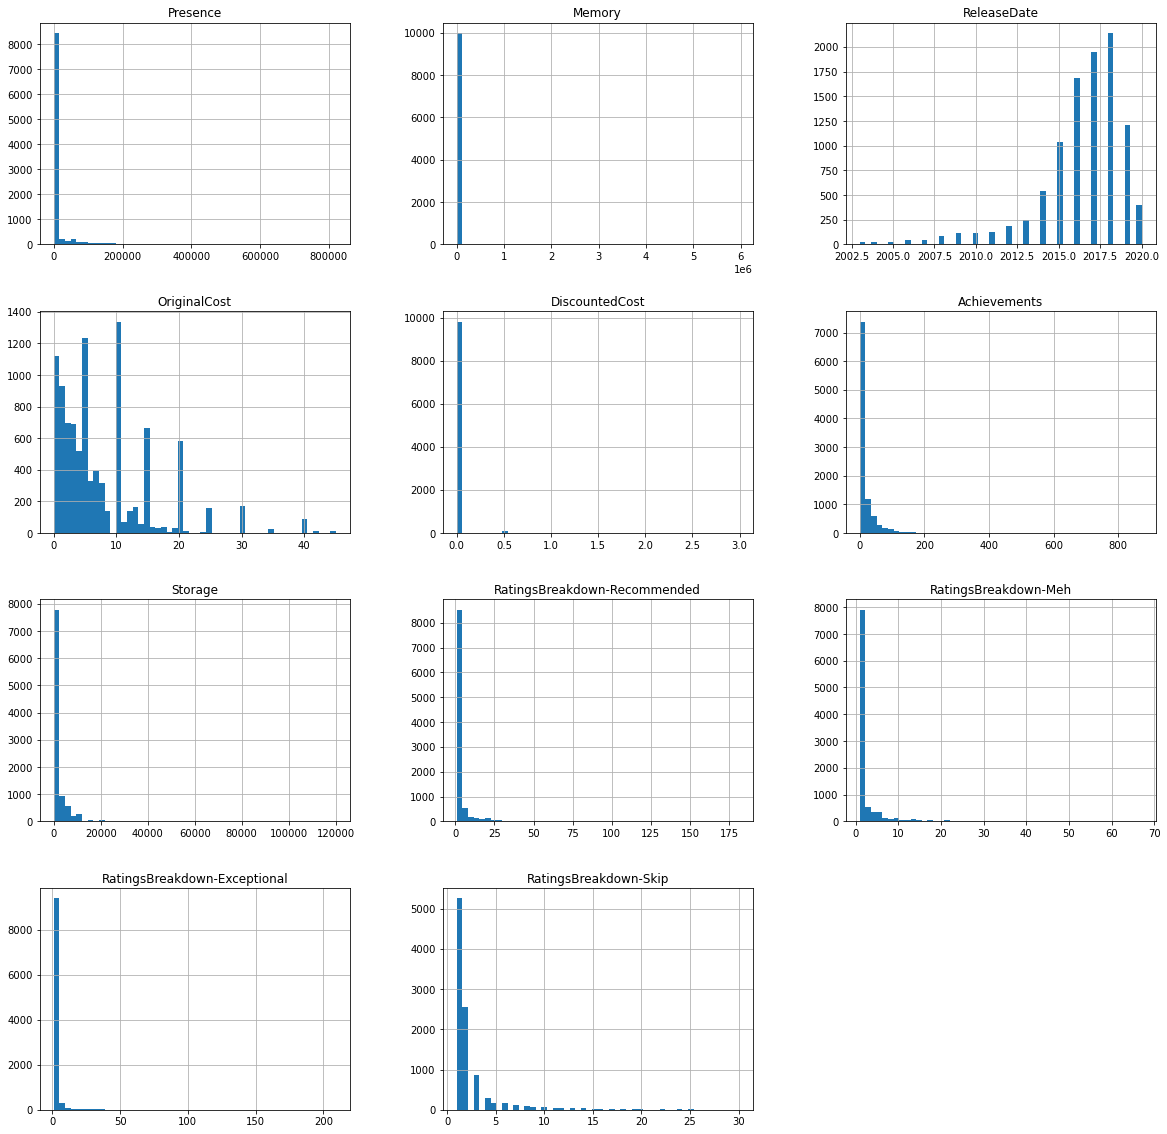

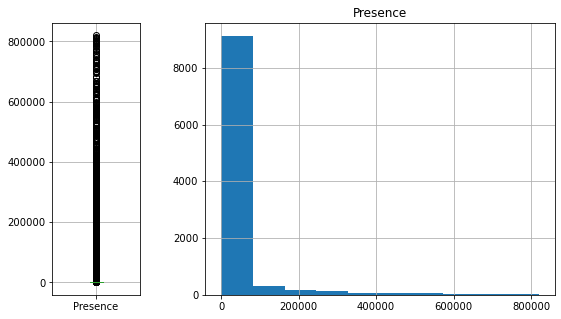

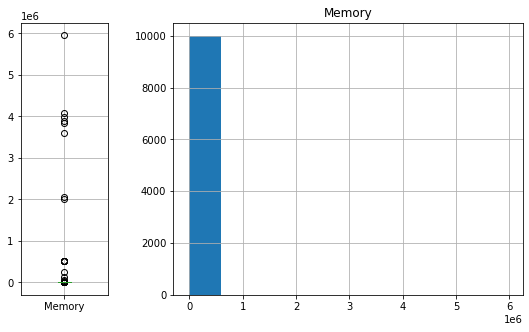

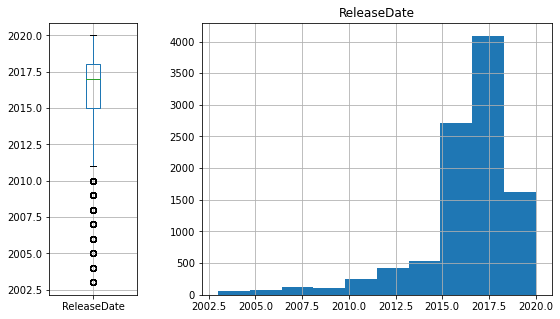

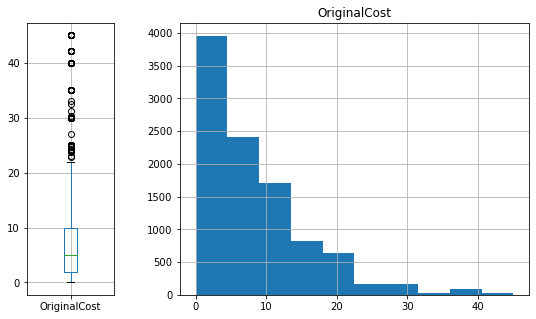

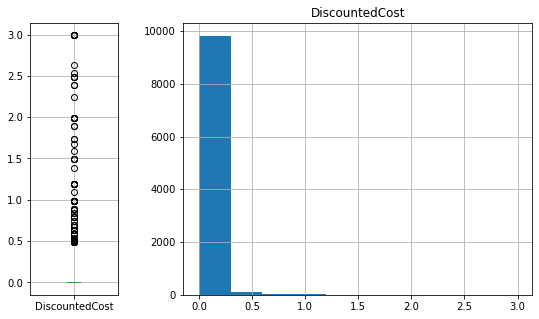

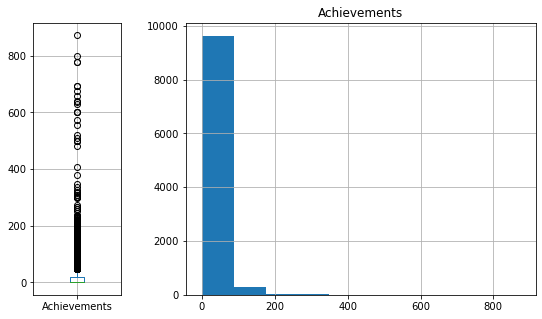

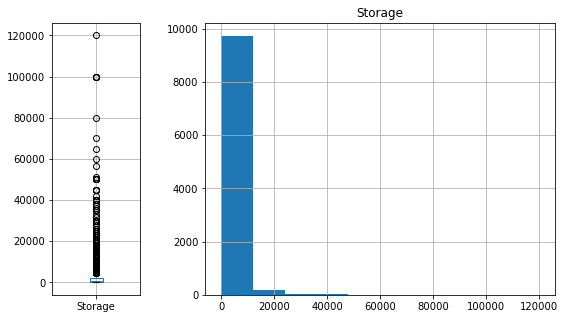

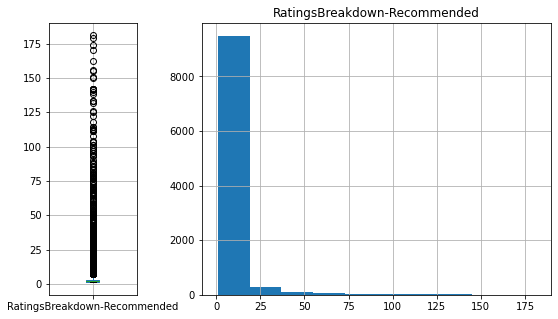

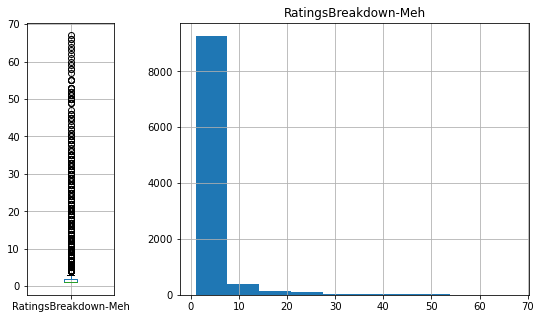

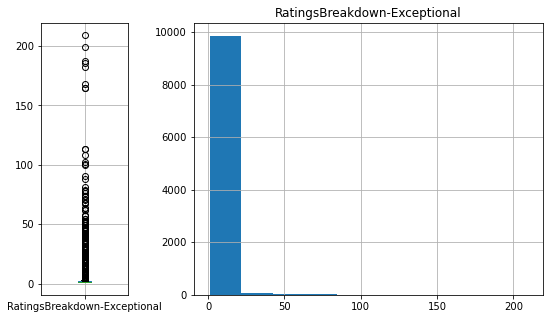

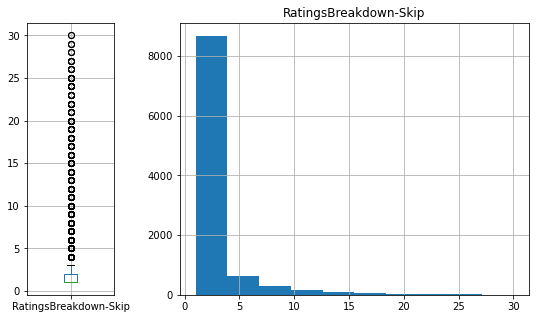

In [54]:
data = data[['Presence',
'Memory',
'ReleaseDate',
'OriginalCost',
'DiscountedCost',
'Achievements',
'Storage',
'RatingsBreakdown-Recommended',
'RatingsBreakdown-Meh',
'RatingsBreakdown-Exceptional',
'RatingsBreakdown-Skip']]



hist = data.hist(bins=50, figsize=(20,20))
box = data.boxplot()
plt.xticks(rotation='vertical')
plt.xticks(rotation='horizontal')
for name in data.columns:
    fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
    data.boxplot(column=name,ax=axes[0])
    data.hist(column=name, ax=axes[1])
plt.show()

